# Installation Matlab dans Jupyter Notebook

## Prérequis
- Matlab installé sur la machine
- Jupyter Notebook
- Environnement Anaconda avec python 3.9

## Etapes à suivre
- Créer un environnement virtuel avec la commande suivante : \
`conda create -n matlab python=3.9`
- Activer l'environnement virtuel avec la commande suivante : \
`conda activate matlab`
- Installer le package `matlab_kernel` avec la commande suivante : \
`pip install matlab_kernel`
- Vous pouvez maintenant lancer Jupyter Notebook avec la commande suivante : \
`jupyter notebook`
- Dans Jupyter Notebook, vous pouvez maintenant créer un nouveau notebook avec le kernel `Matlab`

Si vous souhaitez utiliser `Visual Studio Code` pour écrire vos scripts Matlab, vous pouvez installer l'extension `Matlab` pour `Visual Studio Code`.

Si vous souhaitez lancer un Jupyter Notebook dans `Visual Studio Code` avec le kernel `Matlab`, vous pouvez lancer votre notebook dans l'IDE puis vous pouvez changer le kernel dans le menu `Kernel` en haut de la fenêtre. Une autre solution est de lancer un serveur local Jupyter Notebook avec la commande suivante : \
```
jupyter notebook --no-browser --port=8889
```
Puis de s'y connecter via l'extension `Jupyter` pour `Visual Studio Code`.


# Analyse des traces électromagnétiques
Nous allons analyser les traces collectées sur l'appareil à attaquer. En émettant des hypothèses de clés et en les testant sur les traces, nous allons pouvoir déterminer la clé utilisée pour chiffrer les données.

L'algorithme visée est l'AES-128. Il est basé sur 10 tours de chiffrement des données. Chaque tour réalise 3 opérations : 
- une substitution de bits (S-Box)
- un décalage de bits (ShiftRows)
- une multiplication de bits (MixColumns)

Dans notre cas, nous allons partir des textes chiffrés pour remonter l'algorithme sur le dernier tour et ainsi trouver la clé.

Voici un schéma qui illustre l'attaque :\
***Insérer l'image du schéma***

**Temps d'exécution : 40s** (après premier lancement du noyau Matlab)

In [1]:
directory = 'TRACES_DATA_CONVERTED';
load('TRACES_DATA_CONVERTED\keys.mat')
load('TRACES_DATA_CONVERTED\pti.mat')
load('TRACES_DATA_CONVERTED\cto.mat')
load('TRACES_DATA_CONVERTED\traces.mat')

disp('Tailles des matrices :')
disp(['keys : ' num2str(size(keys))])
disp(['pti : ' num2str(size(pti))])
disp(['cto : ' num2str(size(cto))])
disp(['traces : ' num2str(size(traces))])

Tailles des matrices :
keys : 20000     16
pti : 20000     16
cto : 20000     16
traces : 20000   4000



# Affichage de la moyenne des traces
On trace la moyenne des traces sur un graphique. On voit que l'on obtient 12 pics. Or, on sait que l'AES-128 est sur 10 tours. 
Cette différence vient d'une mauvaise implémentation matérielle. C'est notamment pour cela que l'on attaque par le bas de l'algorithme.
=> On attaque sur le 10e round.

**Temps d'exécution : 30s**

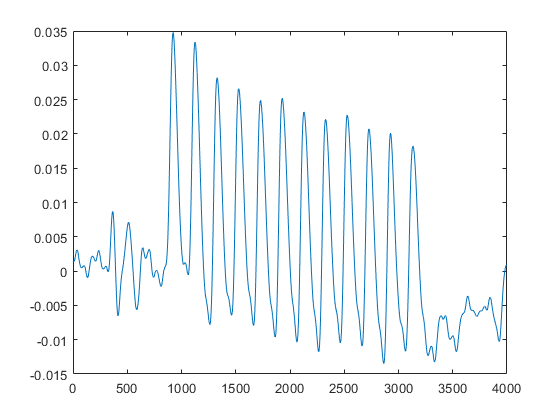

In [2]:
traces_mean = mean(traces);
figure
plot(traces_mean)

## Analyse du graphique
On constate ici que le 10e round est entre 3000 et 3500. On peut donc réduire l'étude à cette plage.

Ainsi, on limite l'analyse et le calcul de la corrélation à la plage [3000,3500].

## Objectif
On cherche à inverser les fonctions de chiffrement. 
Notamment, on cherche à inverser la S_Box.

Etape 1 : on cherche les hypothèses sur les clés => $w_{10}$ \
Etape 2 : on crée toutes les hypothèses pour les sous-clés => $Z$ de dimension $[N_t \times 256]$ \
Etape 3 : on remonte les boîtes de l'algo (ShiftRow et SBox) \
Etape 4 : on fait une corrélation entre les traces et les hypothèses \
Etape 5 : on trouve la meilleure hypothèse pour les clés

Calcul de $w_{10}$ à partir de la clé fourni dans les fichiers des traces.

In [3]:
keys4x4 = reshape(keys(1, :), [4 4])
all_w = keysched2(uint32(keys4x4));

all_w;
w10 = all_w(:, :, 11) % point d'arrivée. Objectif de l'algorithme



keys4x4 =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


w10 =

  4x4 uint32 matrix

    60    64    77    37
    71   214    56   251
    64   128     0   120
     1   146   185   176




## Shiftrow
Cette matrice permet de réaliser le shiftrow de l'AES-128.

In [4]:
shiftrow = [1, 6, 11, 16, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12];
shiftrow = reshape(shiftrow, [4 4]);

# La confusion (SubBytes)
La confusion est une transformation non linéaire par substitution d’octet de l’état interne de l’algorithme de chiffrage.

In [5]:
SBox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22];

invSBox(SBox(1:256) + 1) = 0:255;


## Distance de Hamming
Cette matrice nous permet de calculer directement le poids de Hamming d'une clé. On peut également l'utiliser pour calculer la distance de Hamming entre deux clés.
La définition de la distance de Hamming est la suivante : 
$$d_H(a,b) = \sum_{i=0}^{n-1} (a_i \oplus b_i)$$

In [6]:
Weight_Hamming_vect = [0 1 1 2 1 2 2 3 1 2 2 3 2 3 3 4 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 4 5 5 6 5 6 6 7 5 6 6 7 6 7 7 8];


## Etude sur la première sous-clé
On réalise l'étude complète de l'attaque par analyse des émissions électromagnétiques sur la première sous-clé. Si cette étude est concluante, on pourra généraliser l'attaque sur les autres sous-clés et ainsi obtenir la clé de chiffrement ($w_{10}$).

### Calcul des hypothèses
On calcule les hypothèses en prenant la première sous-clé de la clé fournie dans les fichiers des traces. On obtient donc une matrice de dimension $[N_t \times 256]$. Nos hypothèses sont linéaires.\
On sait qu'une clé peut prendre $2^8 = 256$ valeurs. On a donc $256$ hypothèses.

In [14]:
hypothese = uint8(ones(size(cto, 1), 1) * (0:255));
size(hypothese)
cto_extended = uint8(single(cto(:, 1)) * ones(1, 256));
size(cto_extended)

Z1 = bitxor(cto_extended, hypothese);
size(Z1)
Z3=invSBox(Z1+1);
dh_13 = Weight_Hamming_vect(bitxor(uint8(Z3), uint8(Z1)) + 1);
dh_03 = Weight_Hamming_vect(bitxor(uint8(Z3), uint8(cto_extended)) + 1);
ph_3 = Weight_Hamming_vect(uint8(Z3) + 1);
size(dh_13)

correlation13 = corr(single(dh_13), traces);
size(correlation13)


ans =

       20000         256


ans =

       20000         256


ans =

       20000         256


ans =

       20000         256


ans =

         256        4000




## Affichage de la corrélation
On affiche la corrélation entre les traces et les hypothèses. On voit que la corrélation est maximale pour la courbe en rouge. Cela signifie que cette valeur est la plus probable pour la clé $w_{10}$.

Il est important que la différence entre les courbes bleues et celle rouge soit suffisamment grande pour bien s'assurer de la prédiction de la valeur de la clé.

In [11]:
%%file affiche_correlation.m
function best_candidate = affiche_correlation(correlation)
    %affiche_correlation - Affiche la correlation et renvoie la meilleure correlation
    %
    % Syntax: best_candidate = affiche_correlation(correlation)
    %
    % Cette fonction permet de comparer plusieurs correlations et de renvoyer les meilleures candidats correspondants.
    [RK, IK] = sort(max(abs(correlation), [], 2), 'descend');
    figure
    plot((0:size(correlation, 2) - 1), correlation(IK(1), :), 'r')
    hold on

    if IK(1) == 1
        plot((0:size(correlation, 2) - 1), correlation(2:end, :), 'b')
    else

        if IK(1) == 16
            plot((0:size(correlation, 2) - 1), correlation(1:end - 1, :), 'b')
        else
            plot((0:size(correlation, 2) - 1), correlation(1:IK(1) - 1, :), 'b')
            plot((0:size(correlation, 2) - 1), correlation(IK(1) + 1:end, :), 'b')
        end

    end

    best_candidate = IK(1) - 1;
end


Created file 'C:\Users\Mathis\Desktop\Projet EMA\affiche_correlation.m'.



ans =

    60


ans =

    67


ans =

   166




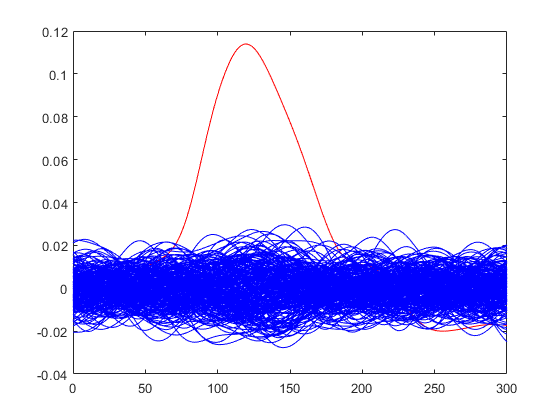

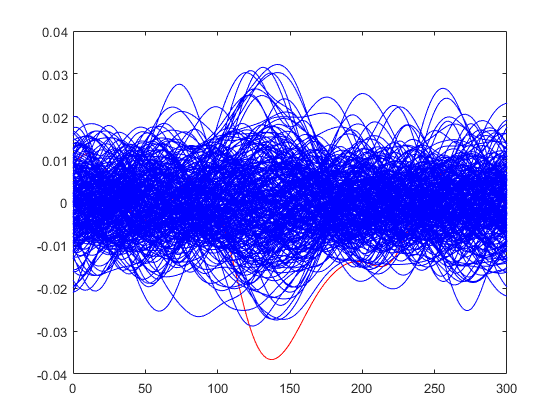

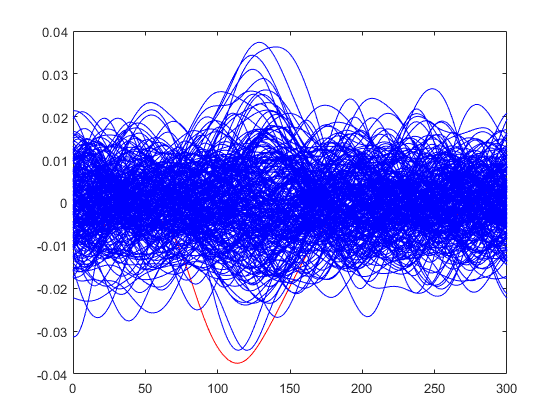

In [13]:
idxmin = 3000;
idxmax = 3300;
correlation = corr(single(dh_03), traces);
correlation = correlation(:, idxmin:idxmax);
affiche_correlation(correlation)
correlation = corr(single(dh_13), traces);
correlation = correlation(:, idxmin:idxmax);
affiche_correlation(correlation)
correlation = corr(single(ph_3), traces);
correlation = correlation(:, idxmin:idxmax);
affiche_correlation(correlation)

## Analyse des corrélations
Après analyse des graphiques ci-dessus, on constate que le calcul de la corrélation permet d'évaluer la qualité du point d'attaque choisi. \
Ainsi, on choisit de réaliser l'attaque entre les points Z0 et Z3 car c'est là où la corrélation est la plus prédominante. \
Cela correspond aux points avant le XOR avec la clé de chiffrement et après la SBox, comme montré par le schéma ci-dessous : 

![points d'attaque possibles](points_attaque_possibles.bmp)

## Choix des points d'attaque
Le choix des points d'attaque est important. Nous avons 6 possibilités de points d'attaque. En effet, nous pouvons utiliser soit le poids de Hamming, soit la distance de Hamming. \
Cela multiplie déjà par 2 le nombre de possibilités. Ensuite, nous pouvons choisir de faire l'attaque entre plusieurs points de l'algorithme.

![Algorithme AES128 - points d'attaque](image_algo_AES128.bmp)

# Programme complet - attaque par analyse EMA
Ci-dessous se trouve le programme complet qui est un assemblage de tous les éléments ci-dessus. Il permet de réaliser l'attaque par analyse EMA.
Le programme renvoie la clé trouvée lors de l'attaque.

Grâce à l'analyse ci-dessus, on peut réaliser l'étude complète afin de déterminer la clé de chiffrement. Il nous suffit d'itérer l'étude pour l'ensemble des 16 sous-clés de la clé de chiffrement. Cependant, il nous reste une dernière étape auquel faire attention : le shiftrow. \
Ce point est discuté ci-dessous.

## Note sur la distance de Hamming et le shiftrow
Pour faire le bon calcul de distance de hamming, il faut comparer les bonnes valeurs entre elles. Ainsi, quand on commence avec la valeur $cto_{1,1}$, on doit la comparer avec la valeur $cto_{1,1}$ après passage dans l'algo. Ensuite, la valeur $cto_{2,1}$ sera comparée avec la valeur $cto_{2,4}$ après passage dans l'algo car on doit faire la comparaison des mêmes valeurs. (Fonctionnement du `shiftrow`)


<!-- Matrices de cto -->
Matrice de cto avant passage dans l'algo : 
$\begin{pmatrix}
\text{cto}_{1,1} & \text{cto}_{1,2} & \text{cto}_{1,3} & \text{cto}_{1,4} \\
\text{cto}_{2,1} & \text{cto}_{2,2} & \text{cto}_{2,3} & \text{cto}_{2,4} \\
\text{cto}_{3,1} & \text{cto}_{3,2} & \text{cto}_{3,3} & \text{cto}_{3,4} \\
\text{cto}_{4,1} & \text{cto}_{4,2} & \text{cto}_{4,3} & \text{cto}_{4,4} \\
\end{pmatrix}$

Matrice de cto après passage dans l'algo :
$\begin{pmatrix}
\text{cto}_{1,1} & \text{cto}_{1,2} & \text{cto}_{1,3} & \text{cto}_{1,4} \\
\text{cto}_{2,4} & \text{cto}_{2,1} & \text{cto}_{2,2} & \text{cto}_{2,3} \\
\text{cto}_{3,3} & \text{cto}_{3,4} & \text{cto}_{3,1} & \text{cto}_{3,2} \\
\text{cto}_{4,2} & \text{cto}_{4,3} & \text{cto}_{4,4} & \text{cto}_{4,1} \\
\end{pmatrix}$

Comme on le constate, le shiftrow n'utilise pas la clé de chiffrement ce qui explique pourquoi on peut faire l'attaque sans tenir compte de ce point, et c'est ce que l'on a fait dans la première partie de l'analyse.

Ici, on doit prendre en compte le shiftrow pour bien réaliser la corrélation entre les points qui correspondent. Ainsi, en appliquant le shiftrow, on garantit que les valeurs comparées sont les mêmes. Cela permet de trouver les bonnes valeurs de la clé et déchiffrer $w_{10}$.

Démonstration et tests de la fonction `circshift` pour réaliser le `shiftrow` :

In [28]:
line = 1:16;
line = reshape(line, [4 4]);
line

for i = 1:4

    disp(line(i, :))
    line(i, :) = circshift(line(i, :), i - 1);
    disp(line(i, :))
    line(i, :) = circshift(line(i, :), 1 - i);
    disp(line(i, :))

end

line



line =

     1     5     9    13
     2     6    10    14
     3     7    11    15
     4     8    12    16

     1     5     9    13

     1     5     9    13

     1     5     9    13

     2     6    10    14

    14     2     6    10

     2     6    10    14

     3     7    11    15

    11    15     3     7

     3     7    11    15

     4     8    12    16

     8    12    16     4

     4     8    12    16


line =

     1     5     9    13
     2     6    10    14
     3     7    11    15
     4     8    12    16




## Programme principal d'analyse
Programme principal qui réalise l'analyse complète et fournit la clé déchiffrée.

### Prérequis
Avant de lancer ce programme, il faut avoir vérifié les points suivants : 
- bien avoir les fonctions matlab du fichier `fonctions_matlab.ipynb` qui ont été lancé. Cela devrait générer automatiquement des fichiers `.m` dans le même dossier que le fichier `.ipynb`.
- bien avoir lancé l'extraction des données avant de lancer le point suivant.
- bien avoir lancé la première cellule de ce fichier pour charger les données de l'analyse. Cela va charger les données qui ont été extraites depuis le dossier `TRACES_DATA` et les mettre dans un dossier `TRACES_DATA_CONVERTED` qui sera créé automatiquement après extraction des données.

⚠ Penser à vérifier votre configuration MATLAB car des Add-ons peuvent être requis afin de certifier le bon fonctionnement du programme. ⚠

### Lancement du programme
Vous pouvez lancer ce programme en vérifiant bien que votre kernel Matlab est lancé, que vos données sont bien chargées et que vous avez bien vérifié les prérequis.

### Résultats
Le programme va renvoyer la clé de chiffrement déchiffrée ainsi que le $w_{10}$ attendu.


In [29]:
keys4x4 = reshape(keys(1, :), [4 4]);
all_w = keysched2(uint32(keys4x4));
w10 = all_w(:, :, 11) % point d'arrivée. Objectif de l'algorithme. (w10)

SBox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22];

invSBox(SBox(1:256) + 1) = 0:255;

Weight_Hamming_vect = [0 1 1 2 1 2 2 3 1 2 2 3 2 3 3 4 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 4 5 5 6 5 6 6 7 5 6 6 7 6 7 7 8];

% Filtrage des données
idxmin = 3000;
idxmax = 3300;
% Hypothèse linéaire de sous-clés (256 possibilités)
hypothese = uint8(ones(size(cto, 1), 1) * (0:255));

indices = 1:16;
indices = reshape(indices, [4 4]);

for ligne = 1:4
    indices_shifted(ligne, :) = circshift(indices(ligne, :), ligne - 1);

    for colonne = 1:4
        cto_extended = uint8(single(cto(:, indices(ligne, colonne))) * ones(1, 256));
        cto_extended_shifted = uint8(single(cto(:, indices_shifted(ligne, colonne))) * ones(1, 256));
        Z1 = bitxor(cto_extended_shifted, hypothese);
        Z3 = invSBox(Z1 + 1);
        dh_03 = Weight_Hamming_vect(bitxor(uint8(Z3), uint8(cto_extended)) + 1);
        correlation = corr(single(dh_03), traces);
        [RK, IK] = sort(max(abs(correlation), [], 2), 'descend');
        best_candidate(ligne, colonne) = IK(1) - 1;
    end

    best_candidate(ligne, :) = circshift(best_candidate(ligne, :), - (ligne - 1));

end

best_candidate



w10 =

  4x4 uint32 matrix

    60    64    77    37
    71   214    56   251
    64   128     0   120
     1   146   185   176


best_candidate =

    60    64    77    37
    71   214    56   251
    64   128     0   120
     1   146   185   176


